In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jul 31 17:40:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install transformers

In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch.nn.functional as F
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import sklearn.utils
import time
import re


In [6]:
# Retrive the data from stored dataset
dataDir = "/content/drive/MyDrive/WoS/data/X11967"
tsvData = os.path.join(dataDir,"WoSDataset_11967.tsv")

tsvData = np.loadtxt(tsvData, dtype=str, delimiter="\t")
print(np.shape(tsvData))

(11967, 4)


In [7]:
print(tsvData[0:10])

[['2' 'Psychology'
  ' interview anxiety interview performance person perception job interview        '
  'the aim of this study was to investigate a the behavioral cues that are displayed by and trait judgments formed about anxious interviewees and b why anxious interviewees receive lower interview performance ratings the behavioral expression of interview anxiety model was created as a conceptual framework to explore these relations we videotaped and transcribed mock job interviews obtained ratings of interview anxiety and interview performance and trained raters to assess several verbal and nonverbal cues and trait judgments the results indicated that few behavioral cues but several traits were related to interviewee and interviewer ratings of interview anxiety two factors emerged from our factor analysis on the trait judgmentsassertiveness and interpersonal warmth mediation analyses were performed and indicated that assertiveness and interpersonal warmth mediated the relation betwe

In [8]:
allLabels = tsvData[:,0]
domains = tsvData[:,1]
keywords = tsvData[:,2]
abstracts = tsvData[:,3]

In [9]:
labels = np.unique(domains, return_counts=True)[0]
labelCounts=  np.unique(domains, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [1499 2107 1132 1925 1617 1959 1728]


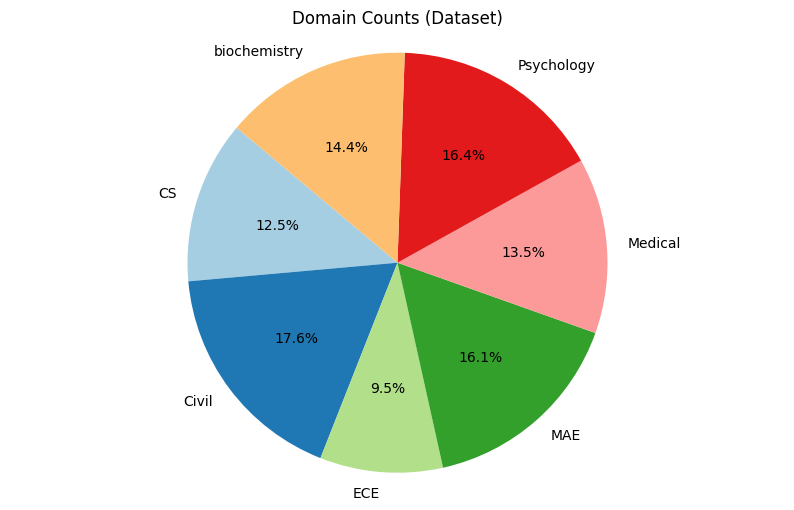

The domain CS has 1499 records in the dataset.
The domain Civil has 2107 records in the dataset.
The domain ECE has 1132 records in the dataset.
The domain MAE has 1925 records in the dataset.
The domain Medical has 1617 records in the dataset.
The domain Psychology has 1959 records in the dataset.
The domain biochemistry has 1728 records in the dataset.


In [10]:
# Visualize domain counts in dataset
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the dataset.")

In [11]:
# Shuffle data
dataShuffled = sklearn.utils.shuffle(tsvData)

abstractsShuffled = dataShuffled[:,3]
keywordsShuffled = dataShuffled[:,2]
domainsShuffled = dataShuffled[:,1]
allLabelsShuffled = dataShuffled[:,0]

print("Number of abstracts: ", len(abstractsShuffled))
print("Shape of abstracts: ", np.shape(abstractsShuffled))
print(abstractsShuffled[0:2])

print("Number of keywords: ", len(keywordsShuffled))
print("Shape of keywords: ", np.shape(keywordsShuffled))
print(abstractsShuffled[0:2])

print("Number of domains: ", len(domainsShuffled))
print("Shape of domains: ", np.shape(domainsShuffled))
print(domainsShuffled[0:2])

print("Number of labels: ", len(allLabelsShuffled))
print("Shape of labels: ", np.shape(allLabelsShuffled))
print(allLabelsShuffled[0:2])


# Convert labels to integer
allLabelsDigitShuffled = allLabelsShuffled.astype(int)

print(abstractsShuffled[0:10])
print(keywordsShuffled[0:10])
print(domainsShuffled[0:10])
print(allLabelsShuffled[0:10])
print(allLabelsDigitShuffled[0:10])

Number of abstracts:  11967
Shape of abstracts:  (11967,)
['available cholinergic drugs for treating alzheimers disease ad provide modest symptomatic benefit we hypothesized that coadministration of a peripheral anticholinergic to reduce doselimiting adverse effects aes would enable the safetolerable use of higher cholinesterase inhibitor doses and thus improve their antidementia efficacy a modified singleblind ascendingdose phase iia study of donepezil plus solifenacin cpc201 lasting 26 weeks was conducted in 41 patients with probable ad of moderate severity entry criteria included the use of donepezil at a dose of 10 mgday during the preceding 3 months the primary outcome measure was the maximum tolerated dose mtd of donepezil achieved to protocol limit of 40 mgday when administered with the anticholinergic solifenacin 15 mgday secondary measures included assessments of cognitive and global function as well as of aes the mean  sd donepezil mtd increased to 38  074 mgday median 40 mgd

In [12]:
# Split dataset into training and testing (80/20 split)
train_data, test_data = train_test_split(dataShuffled, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))

# Further split training data into training and validation (80/20 split of training set)
_, val_data = train_test_split(test_data, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))
# Load SciBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16")

(9573, 4)
(2394, 4)
(9573, 4)
(2394, 4)
(479, 4)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [13]:
abstractsTrain = train_data[:,3]
keywordsTrain = train_data[:,2]
domainsTrain = train_data[:,1]
allLabelsTrain = train_data[:,0]

print("Number of abstracts: ",len(abstractsTrain))
print("Shape of abstracts: ",np.shape(abstractsTrain))
print("Number of keywords: ",len(keywordsTrain))
print("Shape of keywords: ",np.shape(keywordsTrain))
print("Number of domains: ",len(domainsTrain))
print("Shape of domains: ",np.shape(domainsTrain))
print("Number of labels: ",len(allLabelsTrain))
print("Shape of labels: ",np.shape(allLabelsTrain))

print(abstractsTrain[0:2])
print(keywordsTrain[0:2])
print(domainsTrain[0:2])
print(allLabelsTrain[0:2])

Number of abstracts:  9573
Shape of abstracts:  (9573,)
Number of keywords:  9573
Shape of keywords:  (9573,)
Number of domains:  9573
Shape of domains:  (9573,)
Number of labels:  9573
Shape of labels:  (9573,)
['the requirements concerning the technical availability as part of the overall equipment effectiveness increase constantly in production nowadays unplanned downtimes have to be prevented via efficient methods predictive conditionbased maintenance represents a valuable approach for fulfilling these demands but precise models for state estimation are missing from the manufacturers point of view the challenge consists in wear models with the capability of specifying the correct components state as well as providing reliable failure forecasts unfortunately nowadays creation of wear models is based on specific stress tests or design of experiments from the manufacturer the integration of the production phase or even data feedback and user knowledge does not take place new potential

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [1207 1657  908 1533 1308 1586 1374]


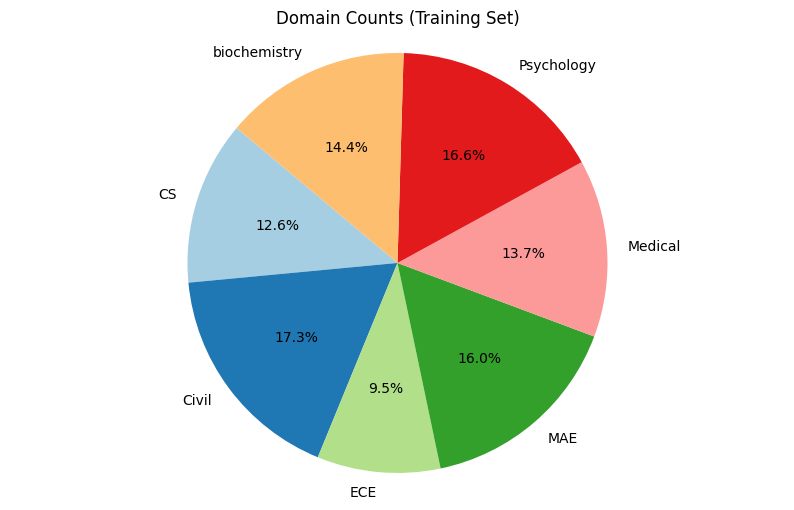

The domain CS has 1207 records in the training set.
The domain Civil has 1657 records in the training set.
The domain ECE has 908 records in the training set.
The domain MAE has 1533 records in the training set.
The domain Medical has 1308 records in the training set.
The domain Psychology has 1586 records in the training set.
The domain biochemistry has 1374 records in the training set.


In [14]:
labels = np.unique(domainsTrain, return_counts=True)[0]
labelCounts =  np.unique(domainsTrain, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsTrain)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Training Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the training set.")

In [15]:
abstractsTest = test_data[:,3]
keywordsTest = test_data[:,2]
domainsTest = test_data[:,1]
allLabelsTest = test_data[:,0]

print("Number of abstracts: ",len(abstractsTest))
print("Shape of abstracts: ",np.shape(abstractsTest))
print("Number of keywords: ",len(keywordsTest))
print("Shape of keywords: ",np.shape(keywordsTest))
print("Number of domains: ",len(domainsTest))
print("Shape of domains: ",np.shape(domainsTest))
print("Number of labels: ",len(allLabelsTest))
print("Shape of labels: ",np.shape(allLabelsTest))

# arr = np.array(domainsTest)
# cleaned_domains = np.char.strip(arr)
# print("Cleaned arr ", cleaned_domains)
# domainsLabelsTest = cleaned_domains
# print("Labels domains ", domainsLabelsTest)

print(abstractsTest[0:2])
print(keywordsTest[0:2])
print(domainsTest[0:2])
print(allLabelsTest[0:2])

Number of abstracts:  2394
Shape of abstracts:  (2394,)
Number of keywords:  2394
Shape of keywords:  (2394,)
Number of domains:  2394
Shape of domains:  (2394,)
Number of labels:  2394
Shape of labels:  (2394,)
['background the incidence of spinal epidural hematoma seh is estimated to be 1 per 1000000 patients per year seh can be classified as idiopathic spontaneous and secondary the cause of spontaneous seh is uncertain but it may be associated with minor trauma seh can compress surrounding structures shown by clinical symptoms and signs that affect the spinal cord or nerve roots surgical treatment may be considered if medical treatment fails case description a 26yearold man presented with lower back pain and significant radicular symptoms on the left side for a week he denied previous lumbar trauma or the use of anticoagulation drugs we used the fullendoscopic transforaminal approach extraforaminal technique to remove the seh under local anesthesia the patient was discharged home 2 

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [292 450 224 392 309 373 354]


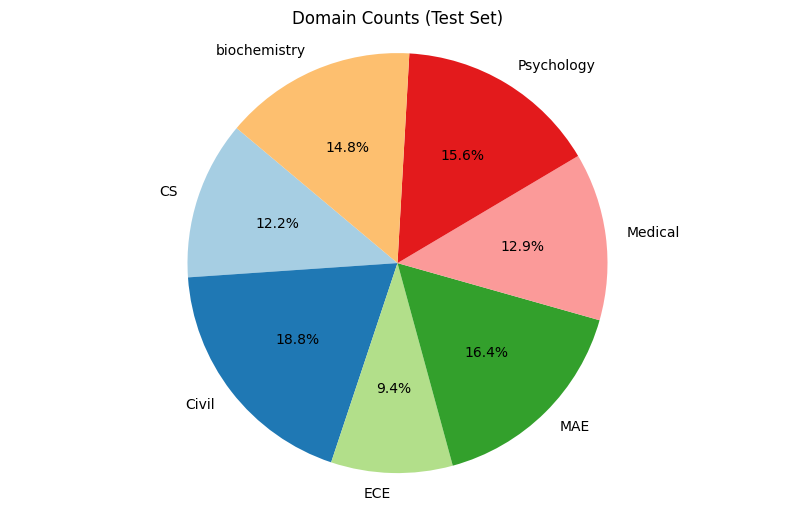

The domain CS has 292 records in the test set.
The domain Civil has 450 records in the test set.
The domain ECE has 224 records in the test set.
The domain MAE has 392 records in the test set.
The domain Medical has 309 records in the test set.
The domain Psychology has 373 records in the test set.
The domain biochemistry has 354 records in the test set.


In [16]:
labels = np.unique(domainsTest, return_counts=True)[0]
labelCounts =  np.unique(domainsTest, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsTest)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Test Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the test set.")

In [17]:
abstractsVal = val_data[:,3]
keywordsVal = val_data[:,2]
domainsVal = val_data[:,1]
allLabelsVal = val_data[:,0]

print("Number of abstracts: ",len(abstractsVal))
print("Shape of abstracts: ",np.shape(abstractsVal))
print("Number of keywords: ",len(keywordsVal))
print("Shape of keywords: ",np.shape(keywordsVal))
print("Number of domains: ",len(domainsVal))
print("Shape of domains: ",np.shape(domainsVal))
print("Number of labels: ",len(allLabelsVal))
print("Shape of labels: ",np.shape(allLabelsVal))

print(abstractsVal[0:2])
print(keywordsVal[0:2])
print(domainsVal[0:2])
print(allLabelsVal[0:2])

Number of abstracts:  479
Shape of abstracts:  (479,)
Number of keywords:  479
Shape of keywords:  (479,)
Number of domains:  479
Shape of domains:  (479,)
Number of labels:  479
Shape of labels:  (479,)
['wireless sensor networks wsns are a collection of several small and inexpensive batterypowered nodes commonly used to monitor regions of interests and to collect data from the environment several issues exist in routing data packets through wsn but the most crucial problem is energy there are a number of routing approaches in wsns that address the issue of energy by the use of different energyefficient methods this paper presents a brief summary of routing and related issues in wsns the most recent energyefficient data routing approaches are reviewed and categorized based on their aims and methodologies the traditional battery based energy sources for sensor nodes and the conventional energy harvesting mechanisms that are widely used to in energy replenishment in wsn are reviewed the

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [58 97 41 75 56 76 76]


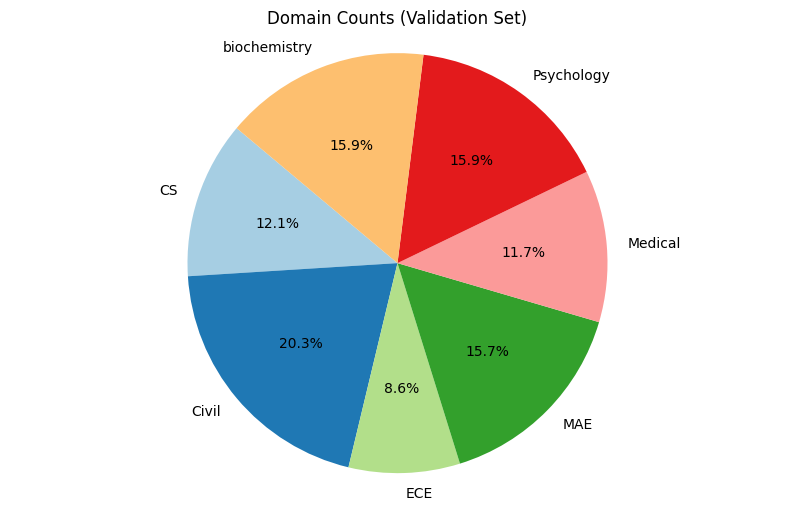

The domain CS has 58 records in the vaidation set.
The domain Civil has 97 records in the vaidation set.
The domain ECE has 41 records in the vaidation set.
The domain MAE has 75 records in the vaidation set.
The domain Medical has 56 records in the vaidation set.
The domain Psychology has 76 records in the vaidation set.
The domain biochemistry has 76 records in the vaidation set.


In [18]:
labels = np.unique(domainsVal, return_counts=True)[0]
labelCounts =  np.unique(domainsVal, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsVal)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Validation Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the vaidation set.")

In [19]:
# Function to tokenize and encode the dataset
def encode_data(data, tokenizer, max_length=128):
    # print(len(data[:,2]))
    inputs = tokenizer(
        data[:,3].tolist(), # abstracts
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )
    # print(len(dataShuffled[:, 0]))
    labels = torch.tensor(data[:, 0].astype(int))
    print("Label length ", len(labels))
    return TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

In [20]:
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))


(9573, 4)
(2394, 4)
(479, 4)


In [21]:
# Encode training, validation, and testing data
train_dataset = encode_data(train_data, tokenizer)
val_dataset = encode_data(val_data, tokenizer)
test_dataset = encode_data(test_data, tokenizer)



# Data loaders
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=32)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)

Label length  9573
Label length  479
Label length  2394


In [22]:
# Load SciBERT model
print(len(np.unique(train_data[:,0])))
model = AutoModelForSequenceClassification.from_pretrained("bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16", num_labels=len(np.unique(train_data[:,0])))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

7


pytorch_model.bin:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [23]:
model.config

BertConfig {
  "_name_or_path": "bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [24]:
# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 20
num_warmup_steps = 1e-4
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
def calculate_metrics(valType, predictions, true_labels):
    # Confusion matrix
    if(valType == 'test'):
        cm = confusion_matrix(true_labels, predictions)
        print("Confusion Matrix:\n", cm)

        # Classification report (includes precision, recall, F1 score)
        report = classification_report(true_labels, predictions, target_names=[str(i) for i in range(len(np.unique(true_labels)))])
        print("\nClassification Report:\n", report)

        # Calculate different types of F1 scores, precision, and recall
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')

        print(f"Macro F1 Score: {f1_macro}")
        print(f"Micro F1 Score: {f1_micro}")
        print(f"Weighted F1 Score: {f1_weighted}")

        print(f"Macro Precision: {precision_macro}")
        print(f"Micro Precision: {precision_micro}")
        print(f"Weighted Precision: {precision_weighted}")

        print(f"Macro Recall: {recall_macro}")
        print(f"Micro Recall: {recall_micro}")
        print(f"Weighted Recall: {recall_weighted}")

    elif(valType == 'val'):
        cm = confusion_matrix(true_labels, predictions)
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')
        # print('Val Micro F1:', f1_micro)
        return f1_micro

In [26]:
epochs = 20
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    start_time = time.time()

    # Training
    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch


        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=input_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation
    model.eval()
    predictions = []
    true_labels = []

    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=input_mask)
            logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        batch_predictions = np.argmax(logits, axis=1)
        predictions.extend(batch_predictions)
        true_labels.extend(label_ids)

    val_micro_f1 = calculate_metrics('val', predictions, true_labels)
    elapsed_time = time.time() - start_time

    # Print epoch summary
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"  Train Loss: {avg_train_loss}")
    print(f"  Val Micro F1: {val_micro_f1}")
    print(f"  Time: {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

Epoch 1/20: 100%|██████████| 300/300 [10:34<00:00,  2.11s/batch]


Epoch 1/20
  Train Loss: 0.7746203962465127
  Val Micro F1: 0.8684759916492694
  Time: 10m 44s


Epoch 2/20: 100%|██████████| 300/300 [10:35<00:00,  2.12s/batch]


Epoch 2/20
  Train Loss: 0.2887838546435038
  Val Micro F1: 0.8977035490605428
  Time: 10m 45s


Epoch 3/20: 100%|██████████| 300/300 [10:34<00:00,  2.12s/batch]


Epoch 3/20
  Train Loss: 0.16479893434482315
  Val Micro F1: 0.8997912317327766
  Time: 10m 45s


Epoch 4/20: 100%|██████████| 300/300 [10:35<00:00,  2.12s/batch]


Epoch 4/20
  Train Loss: 0.09254058681273213
  Val Micro F1: 0.8935281837160751
  Time: 10m 45s


Epoch 5/20: 100%|██████████| 300/300 [10:35<00:00,  2.12s/batch]


Epoch 5/20
  Train Loss: 0.05435442032564121
  Val Micro F1: 0.8830897703549061
  Time: 10m 45s


Epoch 6/20: 100%|██████████| 300/300 [10:35<00:00,  2.12s/batch]


Epoch 6/20
  Train Loss: 0.026393811253947207
  Val Micro F1: 0.8935281837160751
  Time: 10m 45s


Epoch 7/20: 100%|██████████| 300/300 [10:35<00:00,  2.12s/batch]


Epoch 7/20
  Train Loss: 0.014467969948697524
  Val Micro F1: 0.8830897703549061
  Time: 10m 45s


Epoch 8/20: 100%|██████████| 300/300 [10:35<00:00,  2.12s/batch]


Epoch 8/20
  Train Loss: 0.0094761546094378
  Val Micro F1: 0.8935281837160751
  Time: 10m 45s


Epoch 9/20: 100%|██████████| 300/300 [10:35<00:00,  2.12s/batch]


Epoch 9/20
  Train Loss: 0.0033308909784439795
  Val Micro F1: 0.8935281837160751
  Time: 10m 45s


Epoch 10/20: 100%|██████████| 300/300 [10:35<00:00,  2.12s/batch]


Epoch 10/20
  Train Loss: 0.0015481068741792115
  Val Micro F1: 0.8935281837160751
  Time: 10m 45s


Epoch 11/20: 100%|██████████| 300/300 [10:35<00:00,  2.12s/batch]


Epoch 11/20
  Train Loss: 0.0008963524172092244
  Val Micro F1: 0.8935281837160751
  Time: 10m 45s


Epoch 12/20: 100%|██████████| 300/300 [10:35<00:00,  2.12s/batch]


Epoch 12/20
  Train Loss: 0.00033856251766943996
  Val Micro F1: 0.8935281837160751
  Time: 10m 45s


Epoch 13/20: 100%|██████████| 300/300 [10:34<00:00,  2.12s/batch]


Epoch 13/20
  Train Loss: 0.0004202377209003316
  Val Micro F1: 0.8914405010438413
  Time: 10m 45s


Epoch 14/20: 100%|██████████| 300/300 [10:34<00:00,  2.12s/batch]


Epoch 14/20
  Train Loss: 0.002717557712700606
  Val Micro F1: 0.8893528183716075
  Time: 10m 45s


Epoch 15/20: 100%|██████████| 300/300 [10:34<00:00,  2.12s/batch]


Epoch 15/20
  Train Loss: 0.0016223574535979425
  Val Micro F1: 0.8893528183716075
  Time: 10m 45s


Epoch 16/20: 100%|██████████| 300/300 [10:34<00:00,  2.12s/batch]


Epoch 16/20
  Train Loss: 8.819721059505052e-05
  Val Micro F1: 0.8893528183716075
  Time: 10m 45s


Epoch 17/20: 100%|██████████| 300/300 [10:34<00:00,  2.12s/batch]


Epoch 17/20
  Train Loss: 8.271397502539912e-05
  Val Micro F1: 0.8893528183716075
  Time: 10m 45s


Epoch 18/20: 100%|██████████| 300/300 [10:34<00:00,  2.12s/batch]


Epoch 18/20
  Train Loss: 8.286143353567847e-05
  Val Micro F1: 0.8914405010438413
  Time: 10m 45s


Epoch 19/20: 100%|██████████| 300/300 [10:34<00:00,  2.12s/batch]


Epoch 19/20
  Train Loss: 7.608110359190807e-05
  Val Micro F1: 0.8914405010438413
  Time: 10m 45s


Epoch 20/20: 100%|██████████| 300/300 [10:34<00:00,  2.12s/batch]


Epoch 20/20
  Train Loss: 7.034063972241711e-05
  Val Micro F1: 0.8872651356993737
  Time: 10m 45s


In [27]:
# Evaluation
model.eval()
predictions = []
true_labels = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=input_mask)
        logits = outputs.logits

    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    batch_predictions = np.argmax(logits, axis=1)
    predictions.extend(batch_predictions)
    true_labels.extend(label_ids)

# Calculate and print metrics
calculate_metrics('test', predictions, true_labels)

Confusion Matrix:
 [[260   4   0   8  13   2   5]
 [  3 205   1   9   5   0   1]
 [  5   2 349   0   1  14   2]
 [ 11  15   2 350   9   1   4]
 [ 12   7   3   5 415   0   8]
 [  1   2   8   0   1 279  18]
 [  1   2   0   4   7  23 317]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89       292
           1       0.86      0.92      0.89       224
           2       0.96      0.94      0.95       373
           3       0.93      0.89      0.91       392
           4       0.92      0.92      0.92       450
           5       0.87      0.90      0.89       309
           6       0.89      0.90      0.89       354

    accuracy                           0.91      2394
   macro avg       0.90      0.91      0.91      2394
weighted avg       0.91      0.91      0.91      2394

Macro F1 Score: 0.9060055182174865
Micro F1 Score: 0.9085213032581454
Weighted F1 Score: 0.9087125212566527
Macro Precision: 0.90462539540905

In [ ]:
model.save_pretrained('/content/drive/MyDrive/WoS/BlueBERT_WoS_Abstracts_11967')

In [29]:
from google.colab import runtime
runtime.unassign()